[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/upm-classes/aapi_2023/blob/main/neural_transfer_style.ipynb)

# Neural Style Transfer (NST) - Transferencia de Estilo Neural

La Transferencia de Estilo Neural es una técnica en el campo del aprendizaje profundo que permite combinar el contenido de una imagen de referencia con el estilo de otra imagen, creando así una nueva imagen que conserve la estructura del contenido pero adopte el estilo visual de la imagen de referencia. Esto se logra mediante el uso de redes neuronales convolucionales, donde se extraen las características de alto nivel de ambas imágenes y se ajustan para obtener una imagen de salida que refleje el contenido y el estilo deseados. NST es ampliamente utilizado en aplicaciones artísticas y de diseño para crear efectos visuales únicos y estilizados en imágenes y videos.

El proceso de NST implica utilizar una red neuronal convolucional (como VGG19) pre-entrenada para extraer características tanto de la imagen de contenido como de la imagen de estilo. Luego, se ajustan los valores de una imagen de inicio (a menudo una imagen de ruido o una copia de la imagen de contenido) para minimizar la diferencia entre las características de contenido extraídas de la imagen de contenido de referencia y las características de estilo extraídas de la imagen de estilo de referencia. Este proceso de optimización se repite iterativamente hasta que se obtiene una nueva imagen que combina el contenido y el estilo deseado.

<img src="https://raw.githubusercontent.com/upm-classes/aapi_2023/main/images/nst.jpg" width="500">

In [1]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models 
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Imágenes de Contenido y Estilo

Las imágenes de contenido y estilo son componentes fundamentales que se utilizan para generar una nueva imagen combinando características de ambas. Estas imágenes tienen roles específicos en el proceso de transferencia de estilo:

- **Imagen de Contenido:** La imagen de contenido es la imagen base sobre la cual se desea preservar la estructura y el contenido visual. Esta imagen actúa como la "lienzo" sobre el cual se aplicará el estilo de otra imagen. La información de contenido se refiere a las características de alto nivel presentes en la imagen, como formas, objetos y la disposición de elementos.
- **Imagen de Estilo:** La imagen de estilo es aquella de la cual se extraerán los aspectos estilísticos deseados. Esta imagen no se utiliza para preservar el contenido en sí, sino para capturar los patrones de textura, colores, pinceladas y otros elementos estilísticos que caracterizan a la imagen. La información de estilo se obtiene de las correlaciones entre las diferentes características de la imagen.

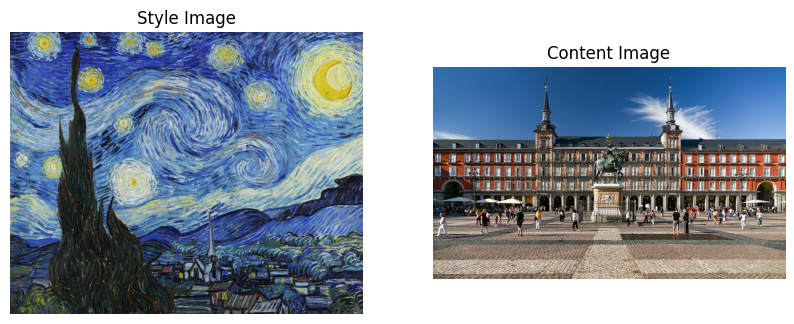

In [2]:
style_image_np = imread('./images/Van_Gogh.jpg')
content_image_np = imread('./images/madrid.jpg')

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(style_image_np), plt.title('Style Image')
plt.axis('off')
plt.subplot(122), plt.imshow(content_image_np), plt.title('Content Image')
plt.axis('off')
plt.show()

In [3]:
def image_to_tensor(img:np.array, image_dimension:int=256) -> torch.Tensor(): 
    """
    Convierte una imagen NumPy en un tensor de PyTorch.

    Parámetros:
        - img (np.array): La imagen de entrada en formato NumPy.
        - image_dimension (int): La dimensión deseada para la imagen (predeterminada: 256).

    Salida:
        - img (torch.Tensor): La imagen convertida en formato de tensor de PyTorch (un tensor 4D).
    """
    # Definir una secuencia de transformaciones de TorchVision para convertir la imagen
    # de NumPy en un tensor de PyTorch
    torch_transformation = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_dimension, image_dimension), antialias=True),
        transforms.ToTensor()
    ])
    # Aplicar las transformaciones a la imagen y agregar una dimensión adicional para representar
    # el lote (batch) de imágenes.
    img = torch_transformation(img).unsqueeze(0)
    return img.to(torch.float)

In [4]:
# Convertir las imágenes en un tensor de PyTorch y moverlo al dispositivo (GPU o CPU).

style_image = image_to_tensor(style_image_np).to(device=device)
content_image = image_to_tensor(content_image_np).to(device=device)

### Gram Matrix

La matriz Gram desempeña un papel fundamental en el proceso NST. Esta matriz es una representación estadística que se utiliza para capturar las correlaciones entre características (como mapas de activación) en una capa específica de una CNN.

A continuación, se explican algunos puntos clave sobre la matriz Gram:

- **Captura de Estilo**: En el contexto de NST, la matriz Gram se utiliza para cuantificar el estilo de una imagen. Se calcula a partir de las activaciones de una o varias capas intermedias de una CNN preentrenada. La idea es que las correlaciones entre características en estas capas reflejan patrones de estilo como texturas, pinceladas y detalles estilísticos.

- **Cálculo de la Matriz Gram**: Para calcular la matriz Gram, se toman las activaciones de una capa y se reorganizan en una matriz bidimensional. Cada fila de la matriz corresponde a un canal de activación, y las columnas representan las ubicaciones espaciales en la imagen. Luego, se realiza una multiplicación de matrices entre esta matriz y su transpuesta.

- **Correlaciones Espaciales y de Estilo**: La matriz Gram captura las correlaciones espaciales y de estilo en las activaciones de la capa. Esto significa que si dos canales tienen patrones de activación similares en la misma ubicación espacial, la matriz Gram tendrá valores más altos para esas combinaciones de canales, lo que indica una mayor similitud de estilo.

- **Normalización**: Para evitar que la matriz Gram esté influenciada por el tamaño de la imagen o el número de canales, generalmente se divide por el producto del número de canales y el número de ubicaciones espaciales. Esto normaliza la matriz y asegura que los valores reflejen la correlación relativa en lugar de la magnitud absoluta.

In [5]:
def calc_gram_matrix(tensor:torch.Tensor()) -> torch.Tensor():
    """
    Calcula la matriz Gram a partir de un tensor de características.

    Parámetros:
        - tensor (torch.Tensor): El tensor de características de una capa de red neuronal.

    Retorna:
        - gram_matrix (torch.Tensor): La matriz Gram calculada a partir del tensor de características.
    """
    # Obtiene las dimensiones del tensor de características.
    num_batch, num_channels, height, width = tensor.size()
    
    # Reorganiza el tensor de características para que sea una matriz 2D.
    feats = tensor.view(num_batch * num_channels, width * height)
    
    # Calcula la matriz Gram multiplicando el tensor por su transposición.
    gram_matrix = torch.mm(feats, feats.t())
    
    # Normaliza la matriz Gram dividiéndola por el número de elementos.
    gram_matrix = gram_matrix.div(num_batch * num_channels * width * height)
    
    return gram_matrix


### VGG19

El proceso de NST implica utilizar una red neuronal convolucional (como VGG19) pre-entrenada para extraer características tanto de la imagen de contenido como de la imagen de estilo. Luego, se ajustan los valores de una imagen de inicio (a menudo una imagen de ruido o una copia de la imagen de contenido) para minimizar la diferencia entre las características de contenido extraídas de la imagen de contenido de referencia y las características de estilo extraídas de la imagen de estilo de referencia. Este proceso de optimización se repite iterativamente hasta que se obtiene una nueva imagen que combina el contenido y el estilo deseado.

In [6]:
# Cargar el modelo VGG19 preentrenado con pesos de ImageNet y moverlo al dispositivo especificado (GPU o CPU).
vgg19_model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).to(device)

# Quitar las capas de clasificación y dejar solo las capas de características del modelo.
vgg19_model = vgg19_model.features

# Congelar todos los parámetros en las capas de características del modelo.
for param in vgg19_model.parameters():
    param.requires_grad_(False)

In [7]:
# Lista para almacenar los índices de las capas convolucionales en el modelo VGG19.
conv_indices = []

# Iterar a través de todas las capas en el modelo VGG19.
for i in range(len(vgg19_model)):
    # Verificar si la capa actual es una capa de MaxPool2d.
    if vgg19_model[i]._get_name() == 'MaxPool2d':
        # Reemplazar la capa MaxPool2d por una capa AvgPool2d con los mismos parámetros.
        vgg19_model[i] = nn.AvgPool2d(kernel_size=vgg19_model[i].kernel_size, 
                                      stride=vgg19_model[i].stride, 
                                      padding=vgg19_model[i].padding)
    # Verificar si la capa actual es una capa Conv2d.
    elif vgg19_model[i]._get_name() == 'Conv2d':
        # Agregar el índice de la capa convolucional a la lista de conv_indices.
        conv_indices.append(i)

# Crear un diccionario que enumera los índices de las capas convolucionales.
conv_indices = dict(enumerate(conv_indices, 1))

In [8]:
# Definir un diccionario que asigna capas de VGG19 a su función en el modelo de estilo.
layers = {1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}

# Convertir el modelo VGG19 en una lista de módulos de PyTorch.
vgg_layers = nn.ModuleList(vgg19_model)

# Obtener el índice de la última capa convolucional según la configuración en 'layers'.
last_layer_idx = conv_indices[max(layers.keys())]

# Seleccionar las capas del modelo VGG19 hasta la última capa convolucional deseada.
vgg_layers_trimmed = vgg_layers[:last_layer_idx + 1]

# Crear un nuevo modelo Sequential que contiene las capas seleccionadas para la transferencia de estilo.
neural_style_transfer_model = nn.Sequential(*vgg_layers_trimmed)

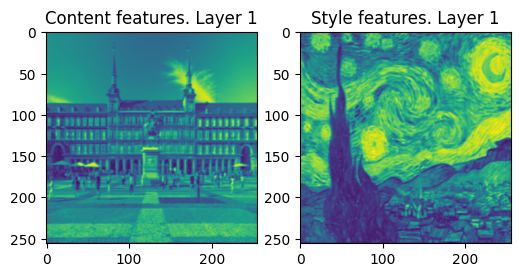

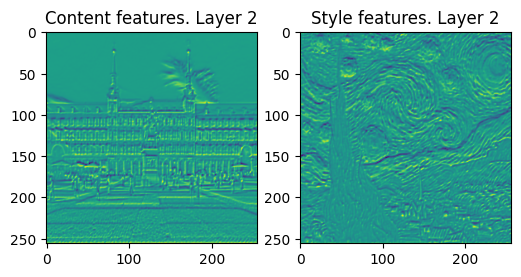

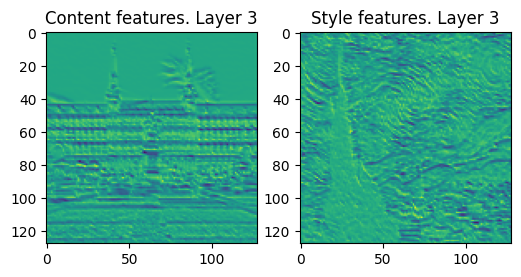

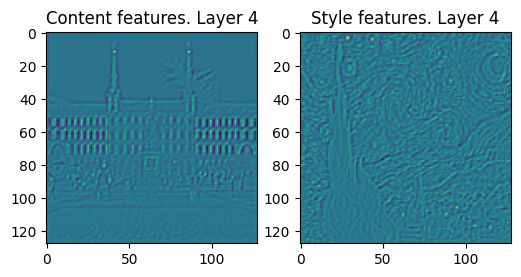

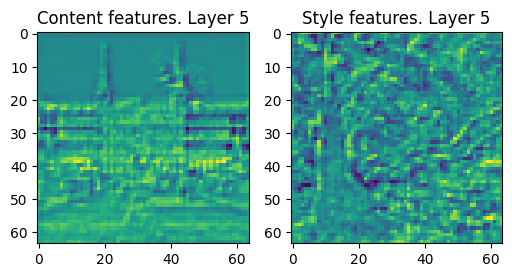

In [9]:
# Ejemplo de los mapas de características extraidos mediantes las capas de VGG19

for i in layers.keys():
    content_feats = neural_style_transfer_model[:conv_indices[i] + 1](content_image).detach().cpu()
    style_feats = neural_style_transfer_model[:conv_indices[i] + 1](style_image).detach().cpu()
    
    plt.figure(figsize=(6, 3))
    plt.subplot(121), plt.imshow(content_feats.squeeze().numpy().transpose(1, 2, 0)[:,:,0])
    plt.title(f'Content features. Layer {i}')
    plt.subplot(122), plt.imshow(style_feats.squeeze().numpy().transpose(1, 2, 0)[:,:,0])
    plt.title(f'Style features. Layer {i}')
    plt.show()

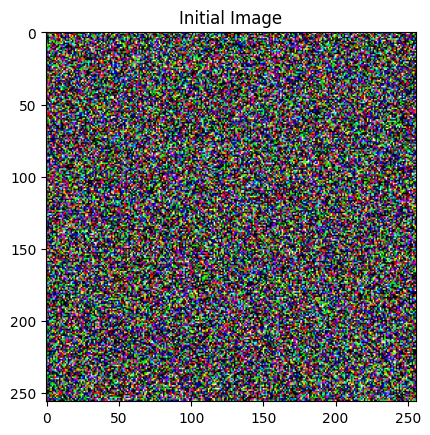

Epoch number: 50
Style loss = 0.6134318709373474, Content loss = 2.5681264400482178


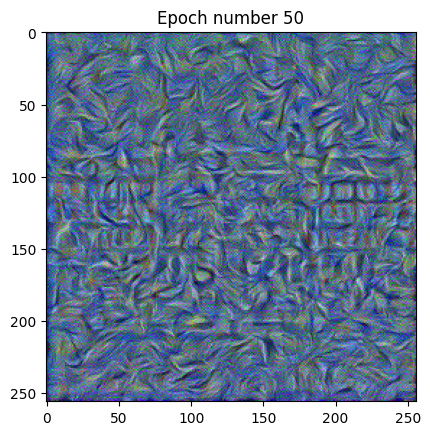

Epoch number: 100
Style loss = 0.2637336254119873, Content loss = 1.0547988414764404


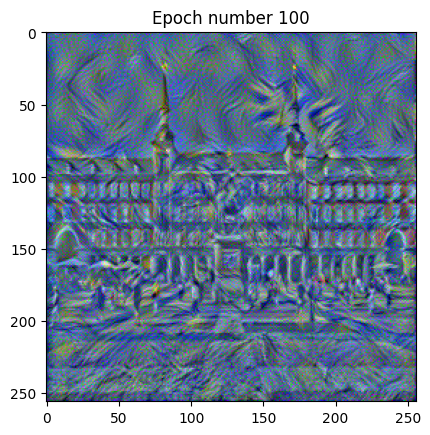

Epoch number: 150
Style loss = 0.2134755402803421, Content loss = 0.7919129729270935


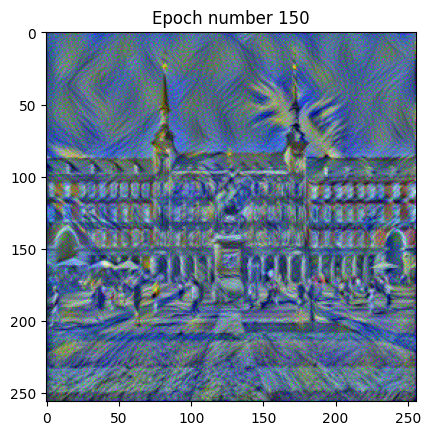

Epoch number: 200
Style loss = 0.18637870252132416, Content loss = 0.7092233300209045


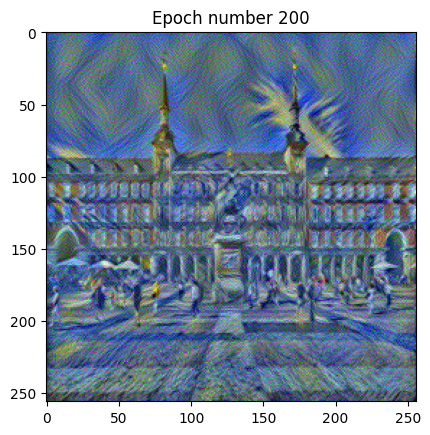

Epoch number: 250
Style loss = 0.1699654459953308, Content loss = 0.6728870868682861


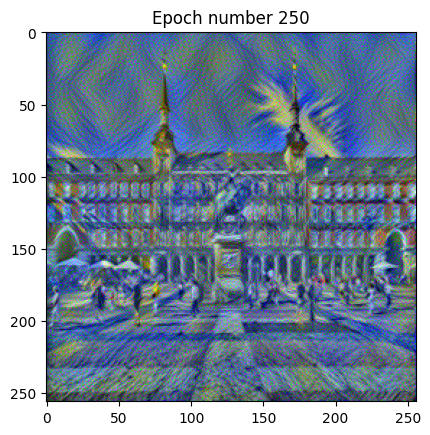

Epoch number: 300
Style loss = 0.15973924100399017, Content loss = 0.6520817875862122


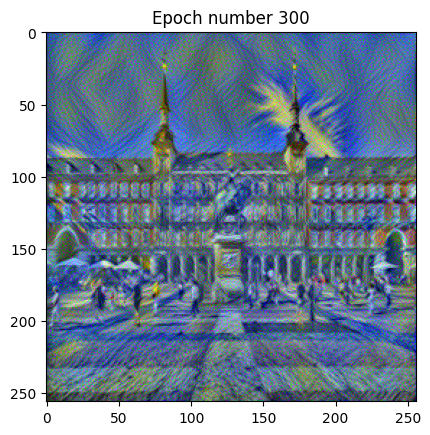

Epoch number: 350
Style loss = 0.1530638337135315, Content loss = 0.6385578513145447


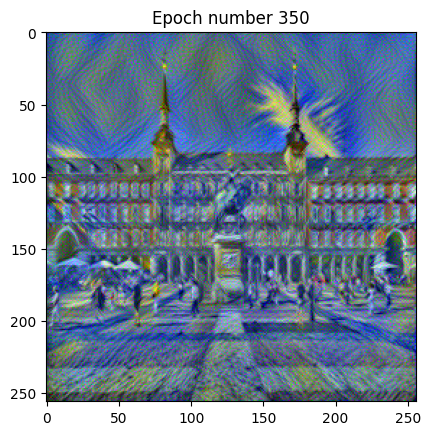

Epoch number: 400
Style loss = 0.148624986410141, Content loss = 0.6292595863342285


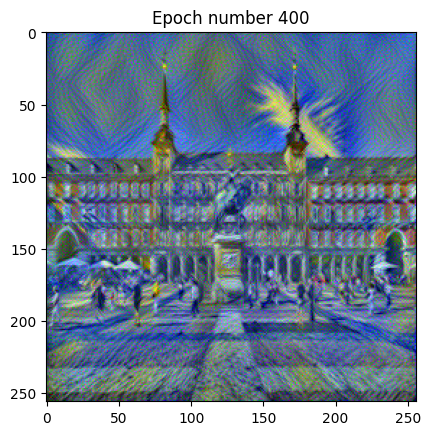

Epoch number: 450
Style loss = 0.1455499827861786, Content loss = 0.622384786605835


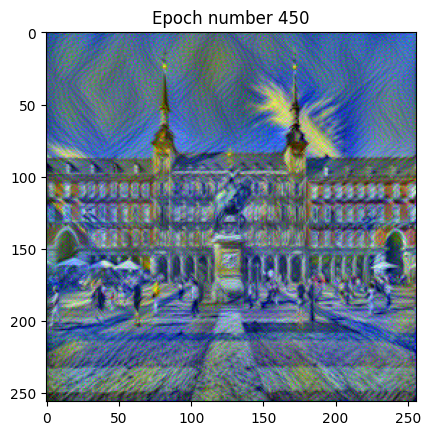

Epoch number: 500
Style loss = 0.14326301217079163, Content loss = 0.6173439025878906


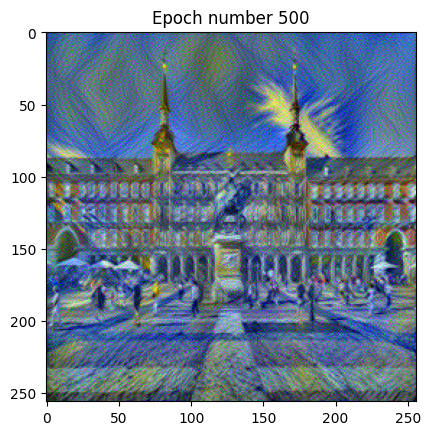

In [10]:
# Número de épocas de entrenamiento.
num_epochs = 500

# Ponderaciones para calcular la función de coste de estilo y la pérdida de contenido.
wt_style = 1e6
wt_content = 1

# Listas para almacenar las pérdidas de estilo y contenido en cada época.
style_losses = []
content_losses = []

# Inicializar la imagen de entrada con valores aleatorios.
torch.manual_seed(0)
ip_image = torch.randn(content_image.data.size(), device=device)

# Mostrar la imagen de entrada inicial.
plt.figure()
plt.imshow(ip_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0).clip(0, 1))
plt.title('Initial Image')
plt.show()

# Optimizador Adam para ajustar la imagen de entrada.
optimizer = optim.Adam([ip_image.requires_grad_()], lr=0.1)

# Bucle de entrenamiento a través de las épocas.
for curr_epoch in range(1, num_epochs + 1):
    
    # Asegurarse de que los valores de los píxeles de la imagen de entrada estén en el rango [0, 1].
    ip_image.data.clamp_(0, 1)
    
    # Reiniciar los gradientes del optimizador.
    optimizer.zero_grad()
    
    # Pérdidas de estilo y contenido acumuladas en esta época.
    epoch_style_loss = 0
    epoch_content_loss = 0

    # Calcular la función de coste de estilo y contenido para las capas especificadas en 'layers'.
    for k in layers.keys():
        if 'c' in layers[k]:
            target = neural_style_transfer_model[:conv_indices[k] + 1](content_image).detach()
            ip = neural_style_transfer_model[:conv_indices[k] + 1](ip_image)
            epoch_content_loss += torch.nn.functional.mse_loss(ip, target)
        if 's' in layers[k]:
            target = calc_gram_matrix(neural_style_transfer_model[:conv_indices[k] + 1](style_image)).detach()
            ip = calc_gram_matrix(neural_style_transfer_model[:conv_indices[k] + 1](ip_image))
            epoch_style_loss += torch.nn.functional.mse_loss(ip, target)

    # Aplicar ponderaciones a la función de coste de estilo y contenido.
    epoch_style_loss *= wt_style
    epoch_content_loss *= wt_content
    
    # Calcular el coste total y realizar la retropropagación.
    total_loss = epoch_style_loss + epoch_content_loss
    total_loss.backward()
    
    # Imprimir información y mostrar imágenes de salida en ciertas épocas.
    if curr_epoch % 50 == 0:
        print(f'Epoch number: {curr_epoch}')
        print(f'Style loss = {epoch_style_loss}, Content loss = {epoch_content_loss}')
        plt.figure()
        plt.title(f'Epoch number {curr_epoch}')
        plt.imshow(ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))
        plt.show()
        style_losses += [epoch_style_loss.item()]
        content_losses += [epoch_content_loss.item()]

    # Actualizar los parámetros de la imagen de entrada utilizando el optimizador.
    optimizer.step()


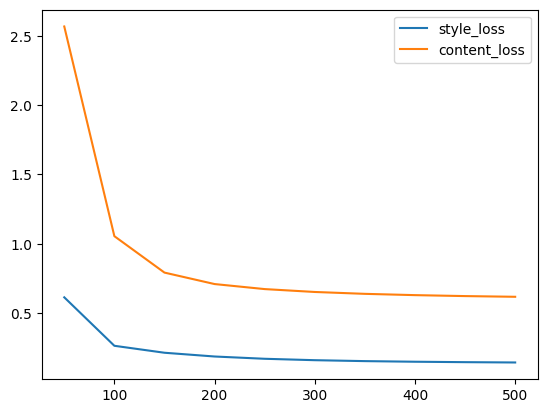

In [11]:
# Crear un gráfico para visualizar el coste de estilo y contenido en función de las épocas.

plt.plot(range(50, num_epochs + 1, 50), style_losses, label='style_loss')
plt.plot(range(50, num_epochs + 1, 50), content_losses, label='content_loss')

plt.legend()
plt.show()